In [1]:
# === 0. Import Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, Dropout, LSTM, Dense, BatchNormalization, 
    Embedding, Flatten, Concatenate, Activation
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber
from sklearn.preprocessing import RobustScaler
import tensorflow as tf

2025-05-08 05:47:43.296040: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746683263.567824      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746683263.642524      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
training_data = pd.read_csv('/kaggle/input/mekong-training-testing-set/salinity_train.csv')
testing_data = pd.read_csv('/kaggle/input/mekong-training-testing-set/salinity_test.csv')

In [3]:
# Convert 'date' column to datetime format
training_data['date'] = pd.to_datetime(training_data['date'])
testing_data['date'] = pd.to_datetime(testing_data['date'])

In [4]:
# Extract month
training_data['month'] = training_data['date'].dt.month
testing_data['month'] = testing_data['date'].dt.month

In [5]:
# Define dry season months (November to April)
dry_months = [1, 2, 3, 4, 5,6]

In [6]:
train = training_data[training_data['month'].isin(dry_months)][['max', 'date', 'Longitude', 'Latitude']]
test = testing_data[testing_data['month'].isin(dry_months)][['max', 'date','Longitude', 'Latitude']]

In [7]:
# Ensure required columns
required_columns = ['date', 'max', 'Latitude', 'Longitude']
train_df = train[required_columns].dropna()
test_df = test[required_columns].dropna()

In [8]:
# === 2. Generate Station ID from Lat/Lon ===
train_df['station_id'] = train_df['Latitude'].round(5).astype(str) + '_' + train_df['Longitude'].round(5).astype(str)
test_df['station_id'] = test_df['Latitude'].round(5).astype(str) + '_' + test_df['Longitude'].round(5).astype(str)

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df['station_code'] = le.fit_transform(train_df['station_id'])
test_df['station_code'] = le.transform(test_df['station_id'])

In [10]:
# === 2. Create Input Arrays ===
def create_inputs_grouped(df, window_size=4, scaler=None):
    X_temp_all, X_spatial_all, station_code_all, y_all = [], [], [], []
    df = df.sort_values(['station_id', 'date'])
    
    if scaler is None:
        scaler_max = RobustScaler()
        scaler_max.fit(df[['max']])
        scaler_coord = MinMaxScaler()
        scaler_coord.fit(df[['Latitude', 'Longitude']])
    else:
        scaler_max, scaler_coord = scaler

    df[['max']] = scaler_max.transform(df[['max']])
    df[['Latitude', 'Longitude']] = scaler_coord.transform(df[['Latitude', 'Longitude']])

    for station, group in df.groupby('station_id'):
        group = group.sort_values('date').reset_index(drop=True)
        code = group['station_code'].iloc[0]
        for i in range(len(group) - window_size):
            seq = group['max'].iloc[i:i+window_size].values.reshape(-1, 1)
            coords = group[['Latitude', 'Longitude']].iloc[i + window_size].values
            target = group['max'].iloc[i + window_size]

            X_temp_all.append(seq)
            X_spatial_all.append(coords)
            station_code_all.append(code)
            y_all.append(target)

    return (np.array(X_temp_all), np.array(X_spatial_all), 
            np.array(station_code_all), np.array(y_all), (scaler_max, scaler_coord))


In [11]:
X_temp_train, X_spatial_train, station_code_train, y_train, (scaler_max, scaler_coord) = create_inputs_grouped(train_df)
X_temp_test, X_spatial_test, station_code_test, y_test, _ = create_inputs_grouped(test_df, scaler=(scaler_max, scaler_coord))

In [12]:
# === 4. Build LSTM + MLP Model ===
temporal_input = Input(shape=(4, 1), name='temporal_input')
spatial_input = Input(shape=(2,), name='spatial_input')

In [13]:
x = Conv1D(64, 3, activation='relu', padding='same')(temporal_input)
x = Dropout(0.2)(x)
x = Conv1D(128, 3, activation='relu', padding='same')(x)
x = Dropout(0.3)(x)

2025-05-08 05:48:01.459299: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [14]:
x = LSTM(64, return_sequences=True, kernel_regularizer=l2(0.003))(x)
x = Dropout(0.3)(x)
x = LSTM(32, return_sequences=False, kernel_regularizer=l2(0.003), recurrent_dropout=0.2)(x)
x = Dropout(0.3)(x)

In [15]:
# === Spatial Branch ===
y = Dense(128)(spatial_input)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = Dropout(0.3)(y)

y = Dense(64)(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)

y = Dense(32, activation='relu')(y)

In [16]:
# Station embedding
station_input = Input(shape=(1,), name='station_input')
station_embed = Embedding(input_dim=len(le.classes_), output_dim=4)(station_input)
station_flat = Flatten()(station_embed)

# Combine spatial MLP and station embedding
spatial_combined = Concatenate()([y, station_flat])

In [17]:
from tensorflow.keras.layers import BatchNormalization
x = Flatten()(x)
# Final merge
merged = Concatenate()([x, spatial_combined])
z = Dense(64, activation='relu')(merged)
z = BatchNormalization()(z)
z = Dropout(0.2)(z)
z = Dense(32, activation='relu')(z)
output = Dense(1)(z)

In [18]:
def quantile_loss(q):
    def loss(y_true, y_pred):
        e = y_true - y_pred
        return tf.reduce_mean(tf.maximum(q * e, (q - 1) * e))
    return loss

#model.compile(loss=quantile_loss(0.9), optimizer='adam')

In [19]:
# === 4. Compile ===
model = Model(inputs=[temporal_input, spatial_input, station_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0002), loss= quantile_loss(0.55), metrics=['mae'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ temporal_input            │ (None, 4, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_input             │ (None, 2)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 4, 64)          │            256 │ temporal_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │            384 │ spatial_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 4, 64)          │              0 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128)            │            512 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 4, 128)         │         24,704 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128)            │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 4, 128)         │              0 │ conv1d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 128)            │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 4, 64)          │         49,408 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 4, 64)          │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64)             │            256 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ station_input             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 32)             │         12,416 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 64)             │              0 │ batch_normalization_1… │
├──────────────────────

 Total params: 105,105 (410.57 KB)

 Trainable params: 104,593 (408.57 KB)

 Non-trainable params: 512 (2.00 KB)

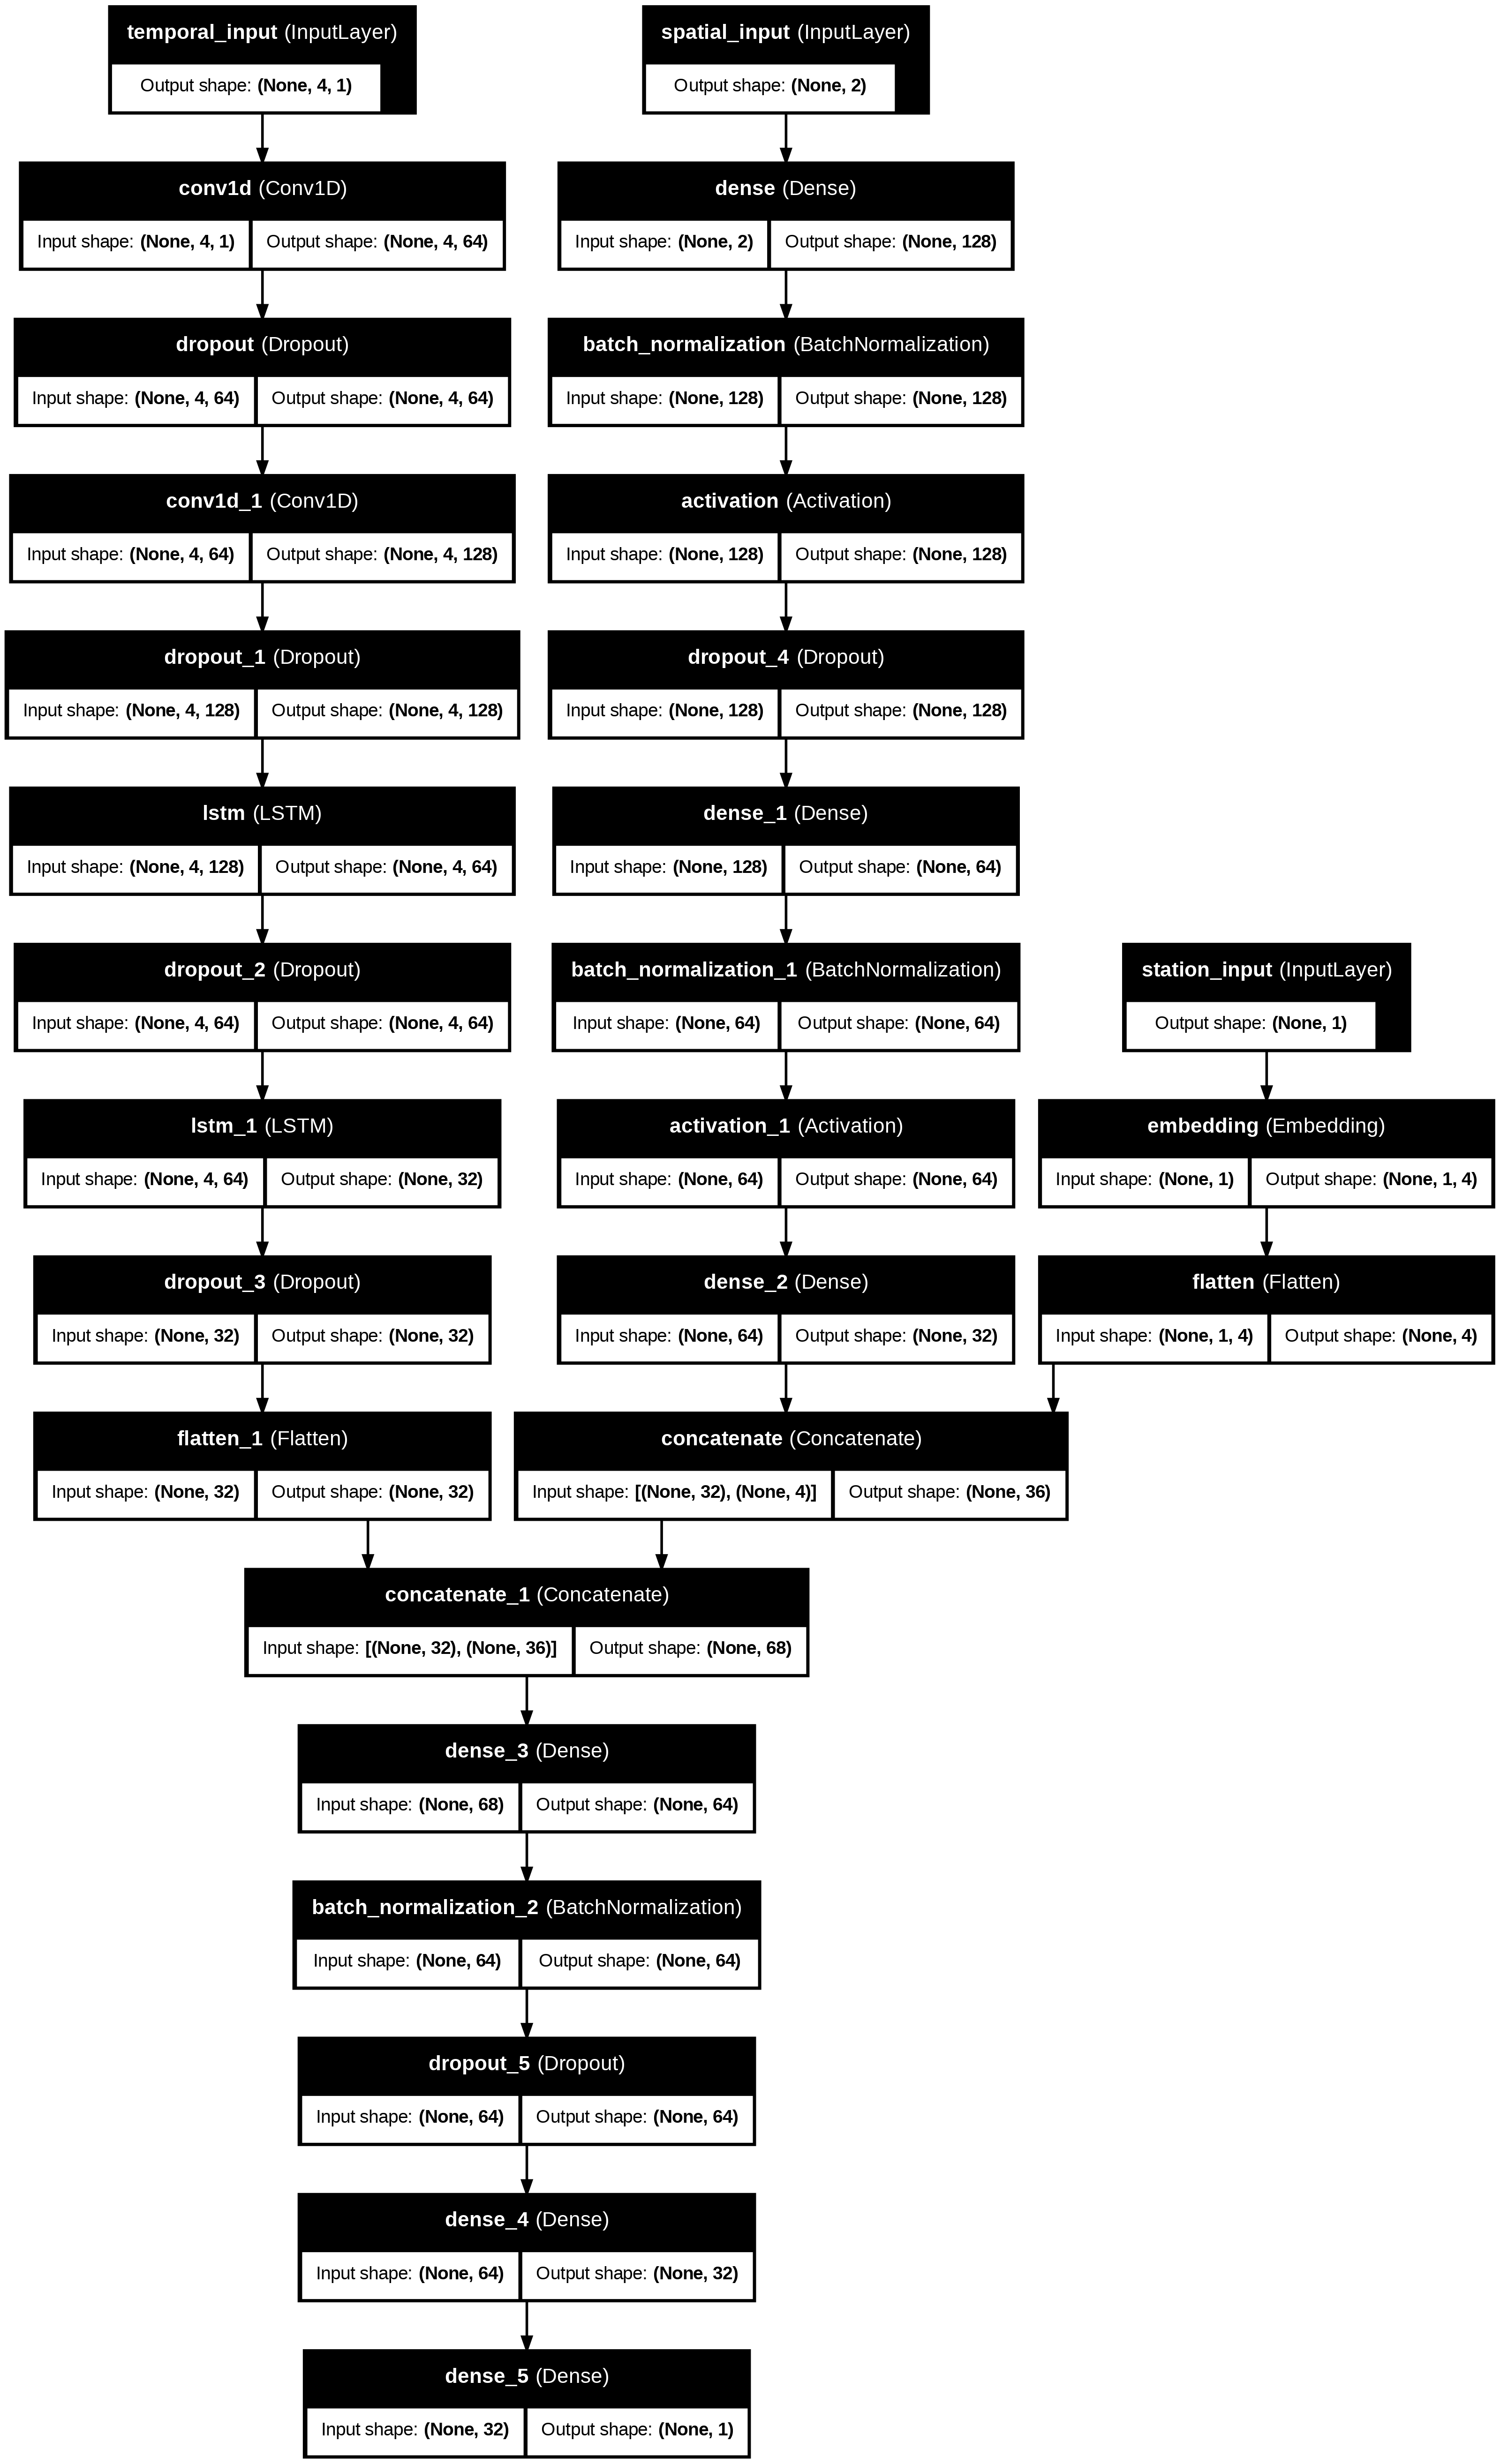

In [20]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [21]:
# === 5. Callbacks ===
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [22]:
history = model.fit(
    [X_temp_train, X_spatial_train, station_code_train], y_train,
    validation_split=0.25,
    epochs=150,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)  # Plotting history/loss as needed


Epoch 1/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 1.1145 - mae: 0.8698 - val_loss: 0.7440 - val_mae: 0.4282 - learning_rate: 2.0000e-04
Epoch 2/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7430 - mae: 0.5569 - val_loss: 0.5505 - val_mae: 0.3704 - learning_rate: 2.0000e-04
Epoch 3/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5415 - mae: 0.4499 - val_loss: 0.4487 - val_mae: 0.3811 - learning_rate: 2.0000e-04
Epoch 4/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4260 - mae: 0.4182 - val_loss: 0.3510 - val_mae: 0.3356 - learning_rate: 2.0000e-04
Epoch 5/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3394 - mae: 0.3710 - val_loss: 0.2560 - val_mae: 0.2572 - learning_rate: 2.0000e-04
Epoch 6/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2863 - mae: 0.3518 - val_loss: 0.2114 - val_mae: 0.2378 - learning_rate: 2.0000e-04
Epoch 7/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2506 - mae: 0.3376 - val_loss: 0.1940 - val_mae: 

In [23]:
# === 5. Predict and Inverse Transform ===
y_pred = model.predict([X_temp_test, X_spatial_test, station_code_test])
y_pred_inv = scaler_max.inverse_transform(y_pred)
y_test_inv = scaler_max.inverse_transform(y_test.reshape(-1, 1))

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


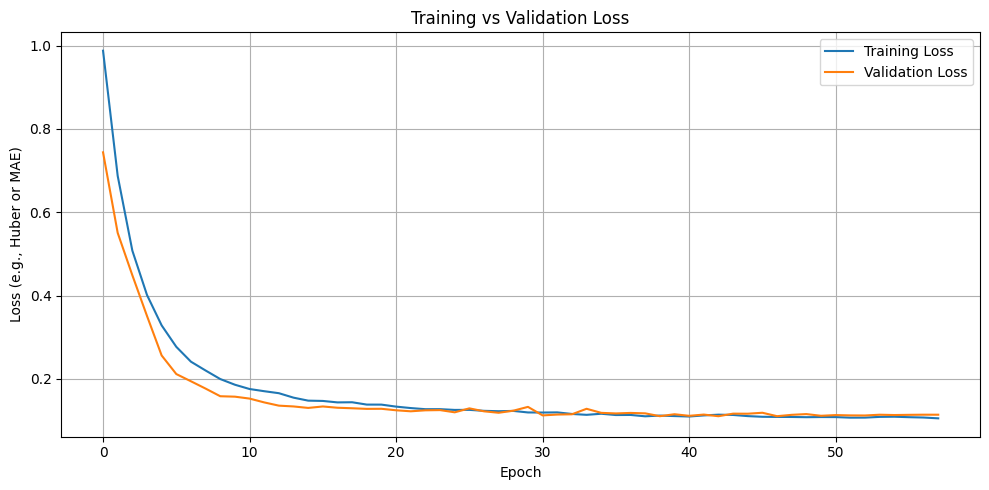

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (e.g., Huber or MAE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

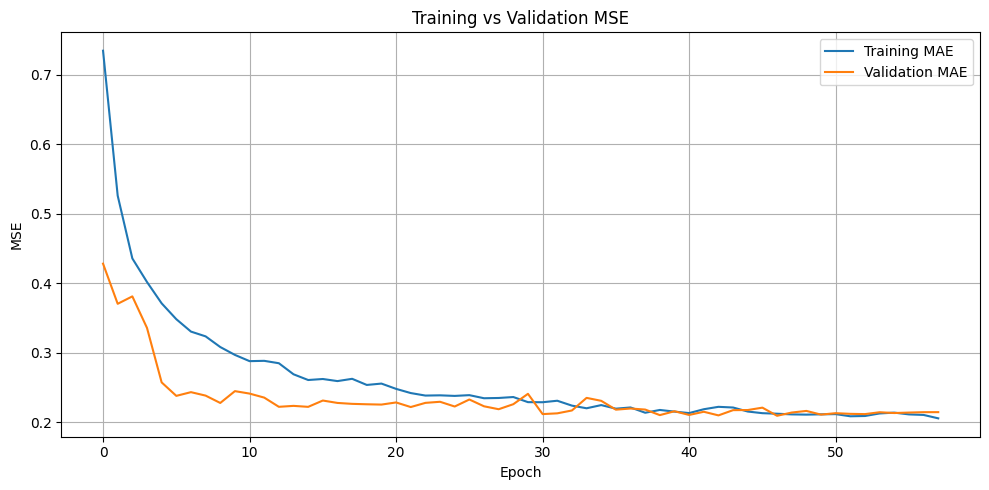

In [25]:
# === 8. Plot MSE ===
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training vs Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
# Step 1: Re-attach metadata (date, lat, lon) to predictions
def get_test_metadata(df, window_size=4):
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['Latitude', 'Longitude', 'date']).reset_index(drop=True)
    df['station_id'] = df['Latitude'].round(5).astype(str) + '_' + df['Longitude'].round(5).astype(str)

    dates, lats, lons, stations = [], [], [], []

    for station, group in df.groupby('station_id'):
        group = group.sort_values('date').reset_index(drop=True)
        for i in range(window_size, len(group)):
            row = group.iloc[i]
            dates.append(row['date'])
            lats.append(row['Latitude'])
            lons.append(row['Longitude'])
            stations.append(station)

    return pd.DataFrame({'station_id': stations, 'date': dates, 'Latitude': lats, 'Longitude': lons})

# Use this to construct result DataFrame
test_meta = get_test_metadata(test_df.copy(), window_size=4)
test_meta['y_true'] = y_test
test_meta['y_pred'] = y_pred.flatten()

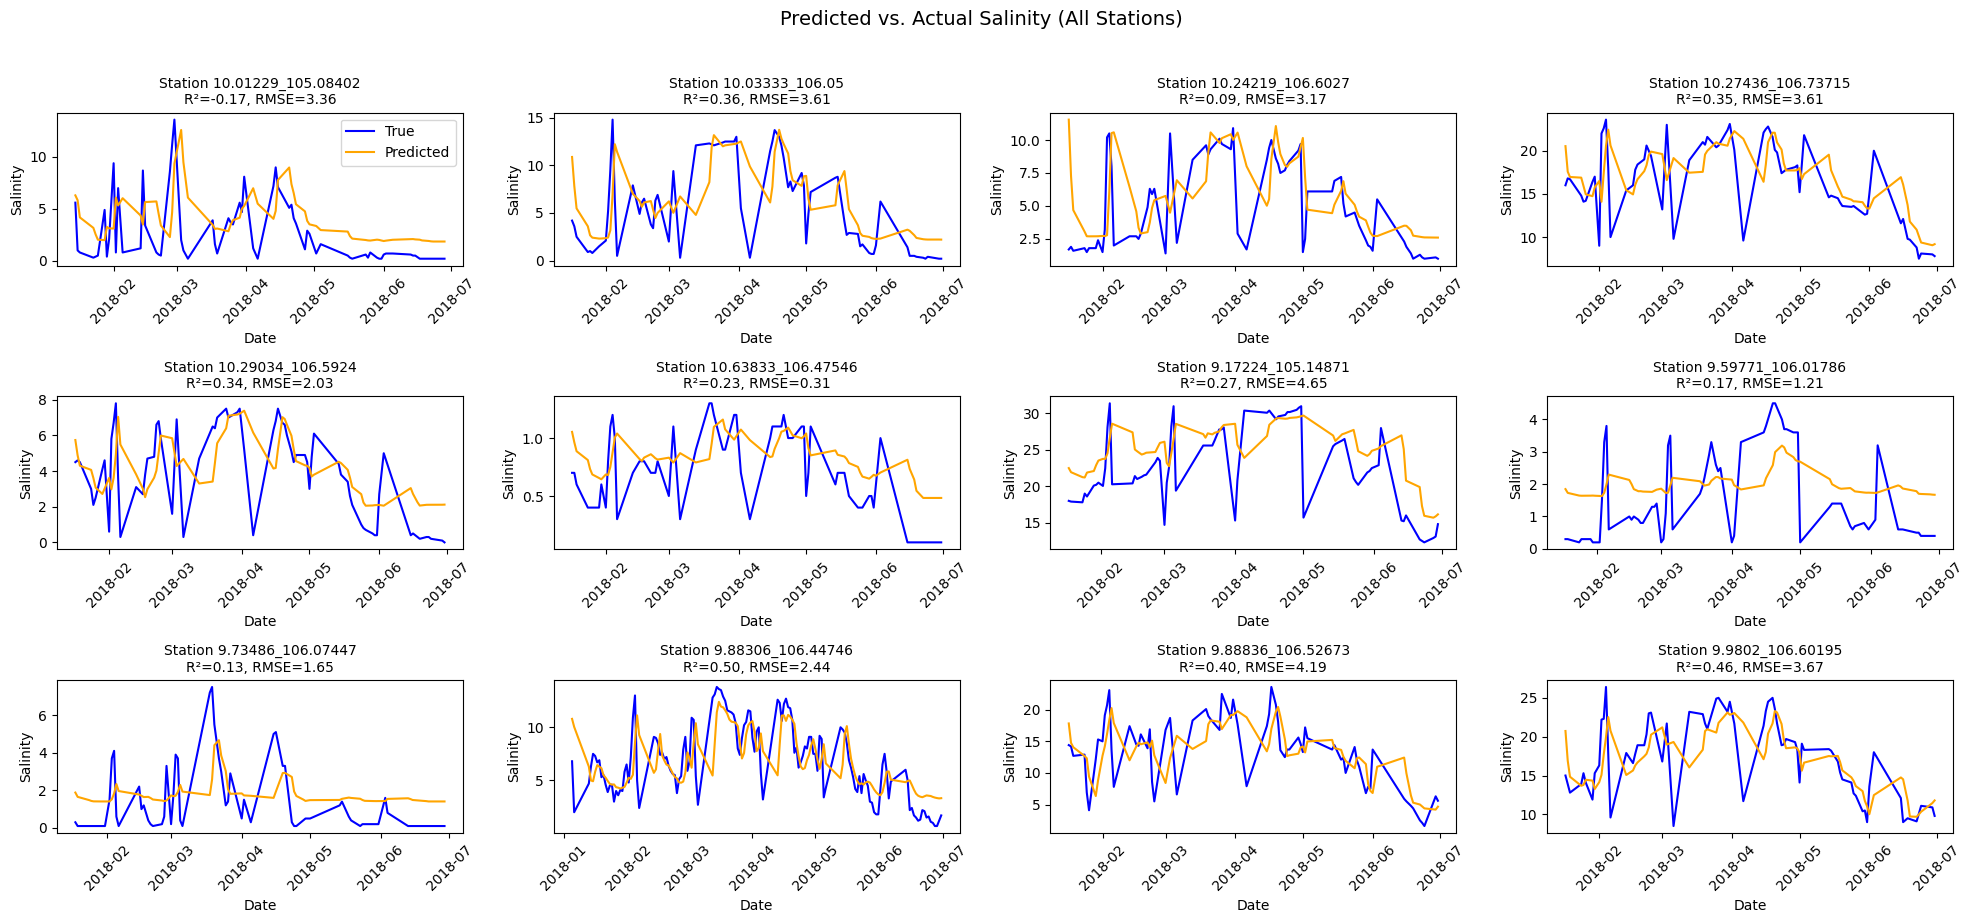

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# === 1. Inverse transform predictions ===
test_meta['y_true'] = scaler_max.inverse_transform(test_meta['y_true'].values.reshape(-1, 1)).flatten()
test_meta['y_pred'] = scaler_max.inverse_transform(test_meta['y_pred'].values.reshape(-1, 1)).flatten()

# === 2. Plot settings ===
test_meta['station_id'] = test_meta['station_id'].astype(str)
unique_stations = test_meta['station_id'].unique()
n_stations = len(unique_stations)

cols = 4
rows = math.ceil(n_stations / cols)

plt.figure(figsize=(cols * 5, rows * 3))

# === 3. Plot per station ===
for i, station in enumerate(unique_stations):
    plt.subplot(rows, cols, i + 1)
    subset = test_meta[test_meta['station_id'] == station].sort_values('date')

    # === Calculate R² and RMSE ===
    r2 = r2_score(subset['y_true'], subset['y_pred'])
    rmse = mean_squared_error(subset['y_true'], subset['y_pred'], squared=False)

    # === Plot ===
    plt.plot(subset['date'], subset['y_true'], label='True', color='blue')
    plt.plot(subset['date'], subset['y_pred'], label='Predicted', color='orange')
    plt.title(f'Station {station}\nR²={r2:.2f}, RMSE={rmse:.2f}', fontsize=10)
    plt.xlabel('Date')
    plt.ylabel('Salinity')
    plt.xticks(rotation=45)
    if i == 0:
        plt.legend()

plt.suptitle('Predicted vs. Actual Salinity (All Stations)', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

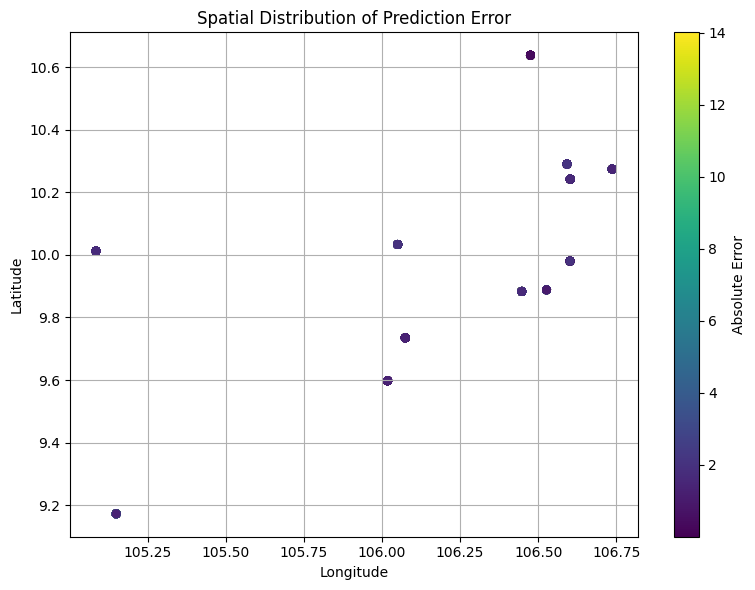

In [28]:
# Plot spatial error
test_meta['error'] = abs(test_meta['y_true'] - test_meta['y_pred'])

plt.figure(figsize=(8, 6))
sc = plt.scatter(test_meta['Longitude'], test_meta['Latitude'], c=test_meta['error'], cmap='viridis', s=30)
plt.colorbar(sc, label='Absolute Error')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution of Prediction Error')
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# If your data is still in a DataFrame:
y_true = test_meta['y_true'].values
y_pred = test_meta['y_pred'].values

# === 1. MAE ===
mae = mean_absolute_error(y_true, y_pred)

# === 2. RMSE ===
rmse = mean_squared_error(y_true, y_pred, squared=False)

# === 3. R² ===
r2 = r2_score(y_true, y_pred)

# === 4. WMAPE ===
def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

wmape_score = wmape(y_true, y_pred)

# === Print results ===
print(f"📊 Test Set Evaluation:")
print(f"• MAE   : {mae:.4f}")
print(f"• RMSE  : {rmse:.4f}")
print(f"• R²    : {r2:.4f}")
print(f"• WMAPE : {wmape_score * 100:.2f}%")

📊 Test Set Evaluation:
• MAE   : 2.1442
• RMSE  : 3.0444
• R²    : 0.8462
• WMAPE : 27.02%


In [30]:
model.save("salinity_model.h5")